##### <font color=#A0A0A0>
##### ════════════════════════════════════════════════════════
#####     🦾🤖 **MODEL TRAINING WITH THE OXFORD DATASET DATASET**
##### ════════════════════════════════════════════════════════ </font>

#### 🎯 Project Objetive
Make a general neural network with some of the most important configurations. Test it with different data sets and track it's performance with differents hyperparameters

In [21]:
# El '!' ejecuta el comando en el terminal de tu notebook
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p C:\\Users\\PERSONAL\\Datasets\\DogsVsCats

dogs-vs-cats-redux-kernels-edition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
zip_file_path = 'C:\\Users\\PERSONAL\\Datasets\\DogsVsCats\\dogs-vs-cats-redux-kernels-edition.zip'
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        
    print("✅ ¡Descompresión completada con éxito!")

except FileNotFoundError:
    print(f"❌ Error: El archivo ZIP no se encontró en la ruta: {zip_file_path}")


✅ ¡Descompresión completada con éxito!


In [24]:
import zipfile
import os

data_path = 'C:\\Users\\PERSONAL\\Datasets\\DogsVsCats' 

files_to_unzip = ['train.zip', 'test.zip'] 

for zip_file_name in files_to_unzip:
    zip_full_path = os.path.join(data_path, zip_file_name)
    
    if os.path.exists(zip_full_path):
        with zipfile.ZipFile(zip_full_path, 'r') as zip_ref:
            zip_ref.extractall(data_path) 

In [26]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BASE_DIR = 'C:\\Users\\PERSONAL\\Datasets\\DogsVsCats' 
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

print("Configuración inicial lista.")

train_cats_dir = os.path.join(TRAIN_DIR, 'cats')
train_dogs_dir = os.path.join(TRAIN_DIR, 'dogs')

os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)

if not os.listdir(train_cats_dir): 
    print("Organizando imágenes de entrenamiento (solo se hace una vez)...")
    file_names = os.listdir(TRAIN_DIR)
    
    for fname in file_names:
        if fname.endswith('.jpg'):
            src = os.path.join(TRAIN_DIR, fname)
            
            if fname.startswith('cat'):
                dst = os.path.join(train_cats_dir, fname)
                shutil.move(src, dst)
            elif fname.startswith('dog'):
                dst = os.path.join(train_dogs_dir, fname)
                shutil.move(src, dst)

print("Organización de la carpeta de entrenamiento completada.")

Configuración inicial lista.
Organizando imágenes de entrenamiento (solo se hace una vez)...
Organización de la carpeta de entrenamiento completada.


In [28]:
train_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary' 
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.dirname(TEST_DIR), 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    
    classes=None, 
    class_mode=None, 
    shuffle=False 
)

print("\n--- RESUMEN DE GENERADORES ---")
print(f"Imágenes de entrenamiento listas: {train_generator.samples}")
print(f"Imágenes de prueba listas: {test_generator.samples}")

test_filenames = test_generator.filenames
print(f"Nombres de archivo de prueba (orden de predicción): {test_filenames[:5]}...")

Found 25000 images belonging to 2 classes.
Found 37500 images belonging to 2 classes.

--- RESUMEN DE GENERADORES ---
Imágenes de entrenamiento listas: 25000
Imágenes de prueba listas: 37500
Nombres de archivo de prueba (orden de predicción): ['test\\1.jpg', 'test\\10.jpg', 'test\\100.jpg', 'test\\1000.jpg', 'test\\10000.jpg']...


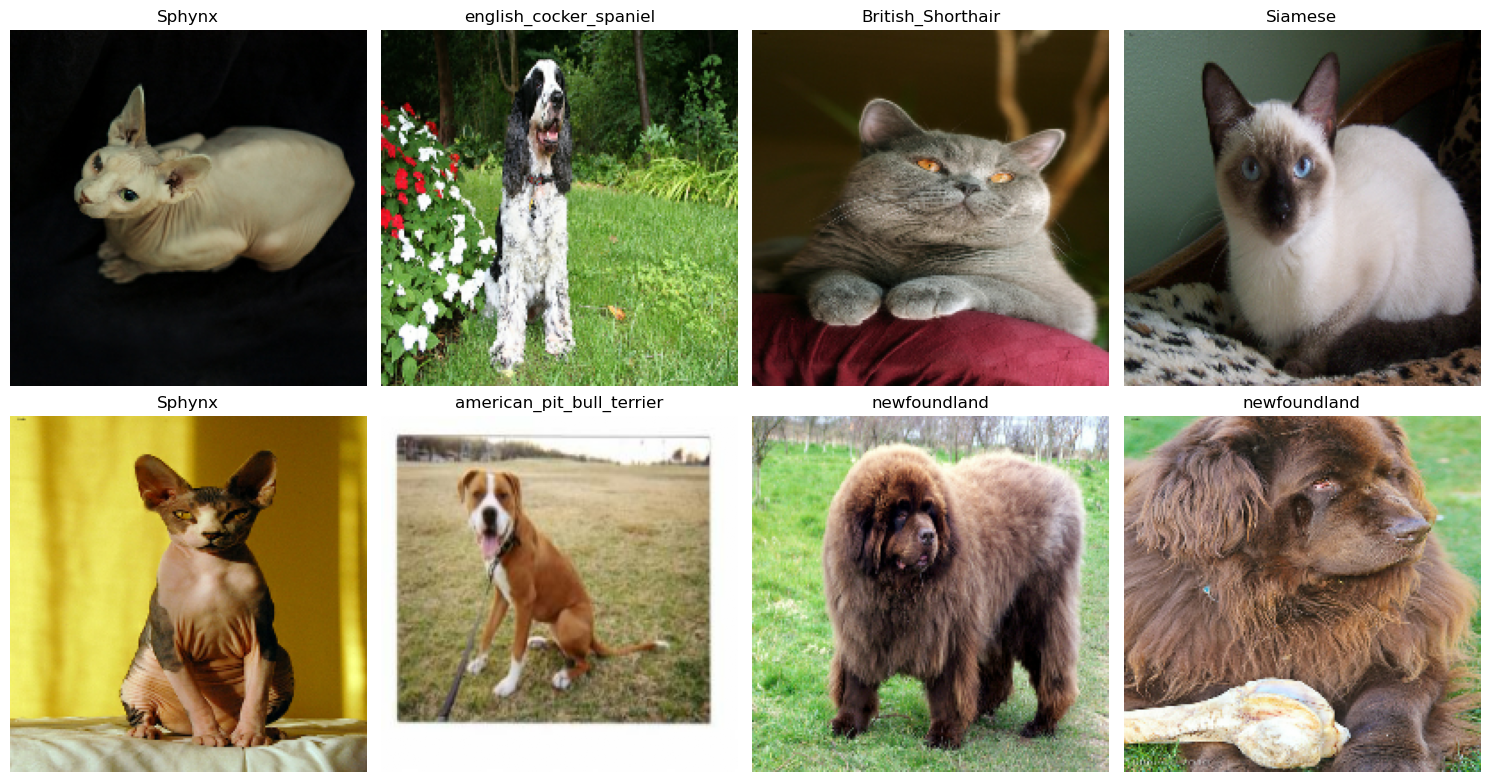

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8),
    tf.TensorSpec(shape=[], dtype=tf.int64)
])
def resize_and_format(image, label):
    image = tf.image.resize(image, [200, 200])
    
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

train_ds = train_ds.map(resize_and_format)
train_ds = train_ds.batch(8)

for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))
    axs = axs.flatten()

    for i in range(8):
        image = images[i].numpy()
        label = labels[i].numpy()

        axs[i].imshow(image)
        class_name = info.features['label'].int2str(label)

        axs[i].set_title(class_name)
        axs[i].axis('off')

plt.tight_layout()
plt.show()

In this part the model will be train with Xception-like architecture but using convolutional layers to compare with the Separable convolutions

In [13]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
inputs = keras.Input(shape=(200,200,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same', use_bias=False) (residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(37, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

train_size = tf.data.experimental.cardinality(train_ds).numpy()
train_split = int(train_size*0.8)
val_split = train_size - train_split

train_ds = train_ds.shuffle(buffer_size=train_size)

x_train_ds = train_ds.take(train_split)
x_val_ds = train_ds.skip(train_split)

def preprocess_data(image, label):
    image = tf.image.resize(image, [224,224])
    label = tf.cast(label, tf.int32)%37
    return image, label

x_train_ds = x_train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
x_val_ds = x_val_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 32
x_train_ds = x_train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
x_val_ds = x_val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='exception_arch_conv.keras',
        save_best_only = True,
        monitor = 'val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    ]

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_history = model.fit(x_train_ds,
                          epochs=30,
                          validation_data = x_val_ds,
                          callbacks = callbacks)

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(val_accuracy) + 1)

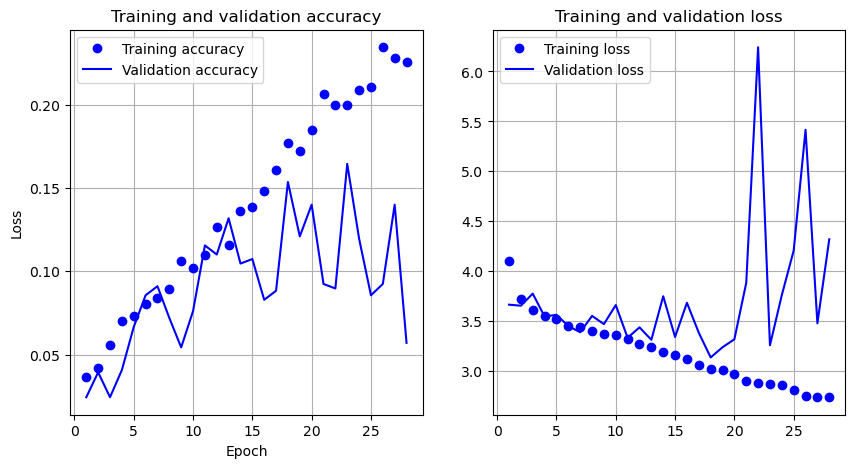

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(epochs, accuracy, 'bo', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
plt.show()

In [ ]:
inputs = keras.Input(shape=(200,200,3))

x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(x)
x= layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same', use_bias=False) (residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(37, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='exception_arch.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )]

model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_history2 = model2.fit(x_train_ds,
                          epochs=30,
                          validation_data = x_val_ds,
                          callbacks = callbacks)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.0350 - loss: 3.6140 - val_accuracy: 0.0312 - val_loss: 3.6054
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.0581 - loss: 3.5518 - val_accuracy: 0.0272 - val_loss: 3.6295
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.0642 - loss: 3.5023 - val_accuracy: 0.0353 - val_loss: 3.6428
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.0768 - loss: 3.4668 - val_accuracy: 0.0312 - val_loss: 3.6659
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.0812 - loss: 3.4290 - val_accuracy: 0.0462 - val_loss: 3.6933
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.0880 - loss: 3.3896 - val_accuracy: 0.0693 - val_loss: 3.4388
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.0914 - loss: 3.3906 - val_accuracy: 0.0611 - val_loss: 3.5443
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.1046 - loss: 3.3490 - val_accuracy: 0.0476 - v

#### <font color=#A0A0A0> **🔘 Selection of hyperparameters**</font>

#### <font color=#A0A0A0> **🧪 Testing the network with another data set**</font>

#### <font color=#A0A0A0> **🧐 Performance Summary**</font>

#### <font color=#A0A0A0> **🧐✅ Conclusions**</font>